In [1]:
from utility import * # 計算基底に関する確率分布を表示

from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix

from qulacs.gate import Identity, X,Y,Z, to_matrix_gate #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

In [2]:
def multi_cnot(q, C_Range, tqubit, circuit):
    if tqubit in C_Range:
        exit(1)
    
    matrix_c = np.array([[0, 0]
                         ,[0, 1]])
    matrix_t = np.array([[1, -1]
                         ,[-1, 1]])
    unit = np.identity(2)
    
    matrix_temp = np.array([1])

    for i in reversed(range(q)):
        if i in C_Range:
            matrix_temp = np.kron(matrix_temp, matrix_c)
        elif i == tqubit:
            matrix_temp = np.kron(matrix_temp, matrix_t)
        else:
            matrix_temp = np.kron(matrix_temp, unit)
            
    gate_matrix = np.identity(2**q) - matrix_temp
    gate = DenseMatrix([i for i in range(q)],gate_matrix) #定義した行列から演算を生成
    circuit.add_gate(gate)

In [3]:
# q=systemqubit+2
def p_left(q, phi, circuit): #right projector
    n = q
    
    for i in range(q-1): # Implement a simple multi 0-controlled
        circuit.add_X_gate(i)
    
    ##### 0-Controlled on all but the last qubits, acts on the last qubit
    multi_cnot(q, [i for i in range(q-1)], q-1, circuit)
    #####
    
    for i in range(q-1): 
        circuit.add_X_gate(i)
        
    #qc.barrier(0, 1, 2, 3)
    circuit.add_RZ_gate(q-1, phi) # RZ(phi) on the last qubit
    #qc.barrier(0, 1, 2, 3)
    
    for i in range(q-1): # Reverse the effect of the first multi-control
        circuit.add_X_gate(i)
    
    ##### 0-Controlled on all but the last qubits, acts on the last qubit
    multi_cnot(q, [i for i in range(q-1)], q-1, circuit)
    #####
    for i in range(q-1):
        circuit.add_X_gate(i)


# q=system_qubit+2
def p_right(q, phi, circuit): # Left projector acts just on the signal and the ancillary qubit
    circuit.add_CNOT_gate(q-2, q-1)
    circuit.add_RZ_gate(q-1, phi) # RZ(phi) on the last qubit
    circuit.add_CNOT_gate(q-2, q-1)
    

#Define Oracle and the reverse-gate for 
#constructing the dagger later
# q=system_qubit+2
def U(q, circuit):
    for i in range(q-2):
        circuit.add_H_gate(i)
    
    ##### 0-Controlled on all system qubits, acts on the signal qubit
    multi_cnot(q, [i for i in range(q-2)], q-2, circuit)
    #####


# q=system_qubit+2
def reverse_U(q, circuit):
    ##### 0-Controlled on all system qubits, acts on the signal qubit
    multi_cnot(q, [i for i in range(q-2)], q-2, circuit)
    #####
    
    for i in range(q-2):
        circuit.add_H_gate(i)

0.9635154816192006 0b01001110


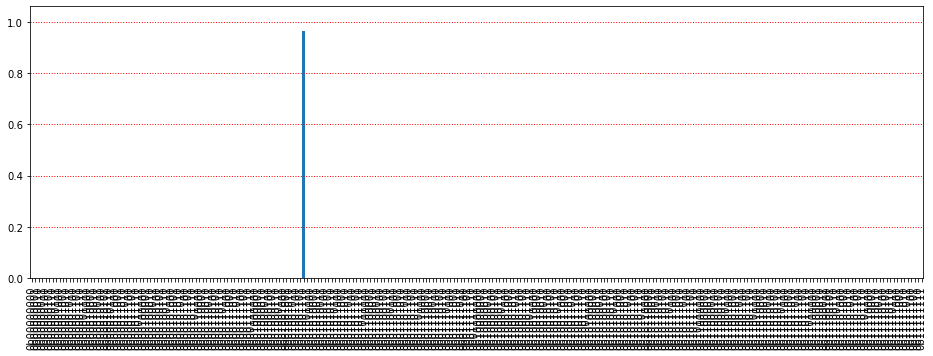

In [19]:
target = "001110"

system_qubits = len(target)
nqubits = system_qubits + 2

############################## d in terms of n!
d = (2*system_qubits) - 1

circuit = QuantumCircuit(nqubits) # 量子回路の用意
state = QuantumState(nqubits)
state.set_zero_state() # |00...0>を準備

if system_qubits > 6 and system_qubits < 10:
    for i in range(1, system_qubits - 6 + 1):
        d += 2 * i
###############################

p_left(nqubits, (1-d)*pi, circuit)
U(nqubits, circuit)

for i in range((d-1)//2):
    p_right(nqubits, pi, circuit) #debug this, doesnt work just as a 2 qubit gate
    reverse_U(nqubits, circuit)
    p_left(nqubits, pi, circuit)
    U(nqubits, circuit)

for i in range(len(target)): # The operation for acquiring arbitrary marked element
    string = target[::-1]      # bitstring is reversed to be compatible with the reverse qubit order in Qiskit
    if string[i] == '0':
        circuit.add_X_gate(i)

circuit.update_quantum_state(state)

prob_distribution = np.abs(state.get_vector())**2
answer = np.amax(prob_distribution)
answer_index = np.argmax(prob_distribution)
print(answer,format(answer_index,'#0'+str(nqubits+2)+'b'))
show_distribution(state)